# Monte Carlo Methods

In this notebook, you will write your own implementations of many Monte Carlo (MC) algorithms. 

While we have provided some starter code, you are welcome to erase these hints and write your code from scratch.

### Part 0: Explore BlackjackEnv

We begin by importing the necessary packages.

In [1]:
import sys
print("Python %s" % sys.version)

Python 3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) 
[GCC 7.3.0]


In [2]:
import gym
print("OpenAI Gym %s" % gym.__version__)

OpenAI Gym 0.14.0


In [3]:
import numpy as np
print("NumPy %s" % np.__version__)

NumPy 1.16.4


In [4]:
import time
from collections import defaultdict
from plot_utils import plot_blackjack_values, plot_policy

Use the code cell below to create an instance of the [Blackjack](https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py) environment.

In [5]:
env = gym.make('Blackjack-v0')

In [6]:
env

Each state is a 3-tuple of:
- the player's current sum $\in \{0, 1, \ldots, 31\}$,
- the dealer's face up card $\in \{1, \ldots, 10\}$, and
- whether or not the player has a usable ace (`no` $=0$, `yes` $=1$).

The agent has two potential actions:

```
    STICK = 0
    HIT = 1
```
Verify this by running the code cell below.

In [7]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


Execute the code cell below to play Blackjack with a random policy.  

(*The code currently plays Blackjack three times - feel free to change this number, or to run the cell multiple times. The cell is designed for you to get some experience with the output that is returned as the agent interacts with the environment.*)

In [8]:
num_episodes = 3
for i_episode in range(num_episodes):
    state = env.reset()
    while True:
        print(state)
        # choose action
        action = env.action_space.sample()
        # get next reward and next state
        state, reward, done, info = env.step(action)
        if done:
            print('End game! Reward: ', reward)
            print('You won :)\n') if reward > 0 else print('You lost :(\n')
            break

(20, 3, False)
(21, 3, False)
End game! Reward:  -1
You lost :(

(20, 10, False)
End game! Reward:  -1
You lost :(

(12, 8, False)
End game! Reward:  -1.0
You lost :(



### Part 1: MC Prediction

In this section, you will write your own implementation of MC prediction (for estimating the action-value function).  

We will begin by investigating a policy where the player _almost_ always sticks if the sum of her cards exceeds 18.  In particular, she selects action `STICK` with 80% probability if the sum is greater than 18; and, if the sum is 18 or below, she selects action `HIT` with 80% probability.  The function `generate_episode_from_limit_stochastic` samples an episode using this policy. 

The function accepts as **input**:
- `bj_env`: This is an instance of OpenAI Gym's Blackjack environment.

It returns as **output**:
- `episode`: This is a list of (state, action, reward) tuples (of tuples) and corresponds to $(S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_{T})$, where $T$ is the final time step.  In particular, `episode[i]` returns $(S_i, A_i, R_{i+1})$, and `episode[i][0]`, `episode[i][1]`, and `episode[i][2]` return $S_i$, $A_i$, and $R_{i+1}$, respectively.

In [9]:
def generate_episode_from_limit_stochastic(bj_env):
    episode = []
    state = bj_env.reset()
    while True:
        # choose action
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
        action = np.random.choice(np.arange(2), p=probs)
        # get next reward and next state
        next_state, reward, done, info = bj_env.step(action)
        # append current state, current action and next reward
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

Execute the code cell below to play Blackjack with the policy. 

(*The code currently plays Blackjack three times - feel free to change this number, or to run the cell multiple times.  The cell is designed for you to gain some familiarity with the output of the `generate_episode_from_limit_stochastic` function.*)

In [10]:
num_episodes = 3
for i in range(num_episodes):
    print(generate_episode_from_limit_stochastic(env))

[((19, 4, False), 0, 0.0)]
[((19, 10, False), 0, -1.0)]
[((14, 1, False), 1, 0), ((19, 1, False), 1, -1)]


Now, you are ready to write your own implementation of MC prediction.  Feel free to implement either first-visit or every-visit MC prediction; in the case of the Blackjack environment, the techniques are equivalent.

Your algorithm has three arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `generate_episode`: This is a function that returns an episode of interaction.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

The algorithm for the First-Visit Monte Carlo Prediction for Action Values.`[1]`

![algo-first-visit-mc-prediction-for-action-values](./images/algo-first-visit-mc-prediction-for-action-values4.png)

In [11]:
def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
    # initialize empty dictionaries of arrays
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.ones(env.action_space.n))
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        ## TODO: complete the function
        # generate episode
        episode = generate_episode(env)
        # pre-calculated discounts
        discounts = [gamma ** i for i in range(len(episode) + 1)]
        # first-visit for each episode
        first_visit = []
        for i, (state, action, reward) in enumerate(episode):
            if (state, action) not in first_visit:
                first_visit.append((state, action))
                # increase count
                N[state][action] += 1.0
                # get discounted return
                G_t = sum([discounts[j] * reward_j \
                           for j, (_, _, reward_j) in enumerate(episode[i:])])
                returns_sum[state][action] += G_t
    
    for state in returns_sum:
        Q[state] = returns_sum[state] / N[state]
        
    return Q

Use the cell below to obtain the action-value function estimate $Q$.  We have also plotted the corresponding state-value function.

To check the accuracy of your implementation, compare the plot below to the corresponding plot in the solutions notebook **Monte_Carlo_Solution.ipynb**.

Episode 500000/500000.

Runtime 110 seconds


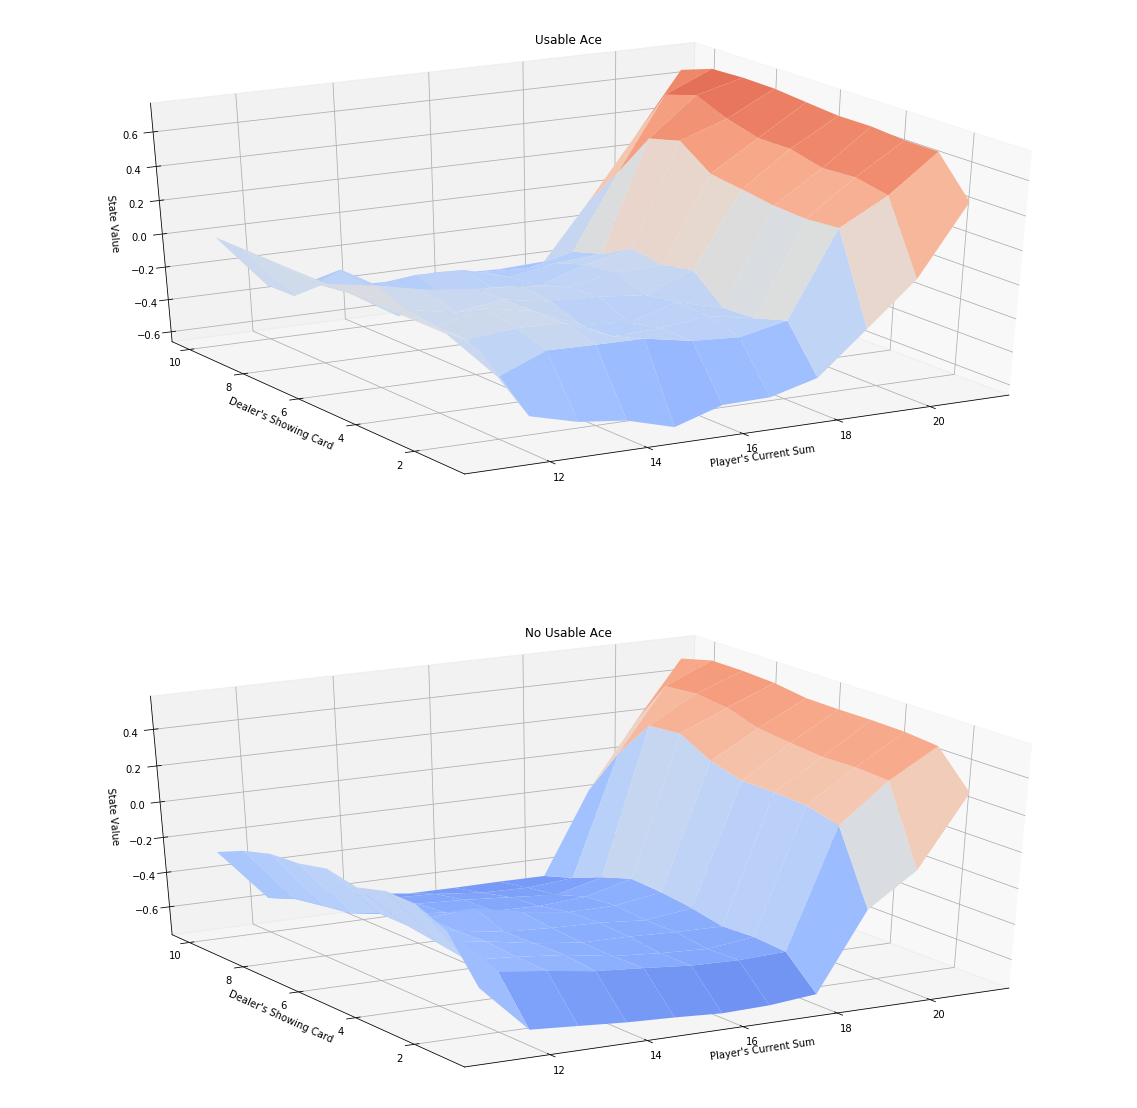

In [12]:
# obtain the action-value function
num_episodes = 500000 # 500000
tic = time.time()
Q = mc_prediction_q(env, num_episodes, generate_episode_from_limit_stochastic)
toc = time.time()
print('\n\nRuntime %d seconds' % int(toc-tic))

# obtain the corresponding state-value function
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V_to_plot)

### Part 2: MC Control

In this section, you will write your own implementation of constant-$\alpha$ MC control.  

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.
- `policy`: This is a dictionary where `policy[s]` returns the action that the agent chooses after observing state `s`.

(*Feel free to define additional functions to help you to organize your code.*)

Epsilon-greedy policies.`[2]`

![function-epsilon-greedy](./images/function-epsilon-greedy.png)

In [74]:
def generate_policy_from_epsilon_greedy(Q, epsilon):
    policy = {}
    for state in Q:
        num_actions = len(Q[state])
        # else
        policy[state] = np.ones(num_actions) * (epsilon / num_actions)
        # if a maximizes Q(s,a)
        max_action = np.argmax(Q[state])
        policy[state][max_action] = (1 - epsilon) + (epsilon / num_actions)

    return policy

In [75]:
def generate_episode_from_policy(bj_env, policy):
    episode = []
    state = bj_env.reset()
    num_actions = bj_env.action_space.n
    while True:
        # choose action
        if state in policy:
            max_q = float(sum(policy[state]))
            probs = [q / max_q for q in policy[state]]
        else:
            probs = [1.0 / num_actions] * num_actions
        action = np.random.choice(np.arange(num_actions), p=probs)
        # get next reward and next state
        next_state, reward, done, info = bj_env.step(action)
        # append current state, current action and next reward
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

The algorithm for the First-Visit Constant-Alpha (GLIE) MC Control.`[1]`

![algo-first-visit-constant-alpha-glie-mc-control](./images/algo-first-visit-constant-alpha-glie-mc-control.png)

In [76]:
def mc_control(env, num_episodes, alpha, gamma=1.0, \
               epsilon_start=1.0, epsilon_decay=0.99999, epsilon_min=0.05):
    nA = env.action_space.n
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    epsilon = epsilon_start
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        ## TODO: complete the function
        # generate policy
        epsilon = max(epsilon * epsilon_decay, epsilon_min)
        policy = generate_policy_from_epsilon_greedy(Q, epsilon)
        # generate episode
        episode = generate_episode_from_policy(env, policy)
        # pre-calculated discounts
        discounts = [gamma ** i for i in range(len(episode) + 1)]
        # first-visit for each episode
        first_visit = []
        for i, (state, action, _) in enumerate(episode):
            if (state, action) not in first_visit:
                first_visit.append((state, action))
                # get discounted return
                G_t = sum([discounts[j] * reward_j \
                           for j, (_, _, reward_j) in enumerate(episode[i:])])
                # update Q table
                Q[state][action] = Q[state][action] + (alpha * (G_t - Q[state][action]))
        
    return policy, Q

Use the cell below to obtain the estimated optimal policy and action-value function.  Note that you should fill in your own values for the `num_episodes` and `alpha` parameters.

In [77]:
# obtain the estimated optimal policy and action-value function
num_episodes = 500000 # 500000
alpha = 0.02
tic = time.time()
policy, Q = mc_control(env, num_episodes, alpha)
toc = time.time()
print('\n\nRuntime %d seconds' % int(toc-tic))

Episode 500000/500000.

Runtime 647 seconds


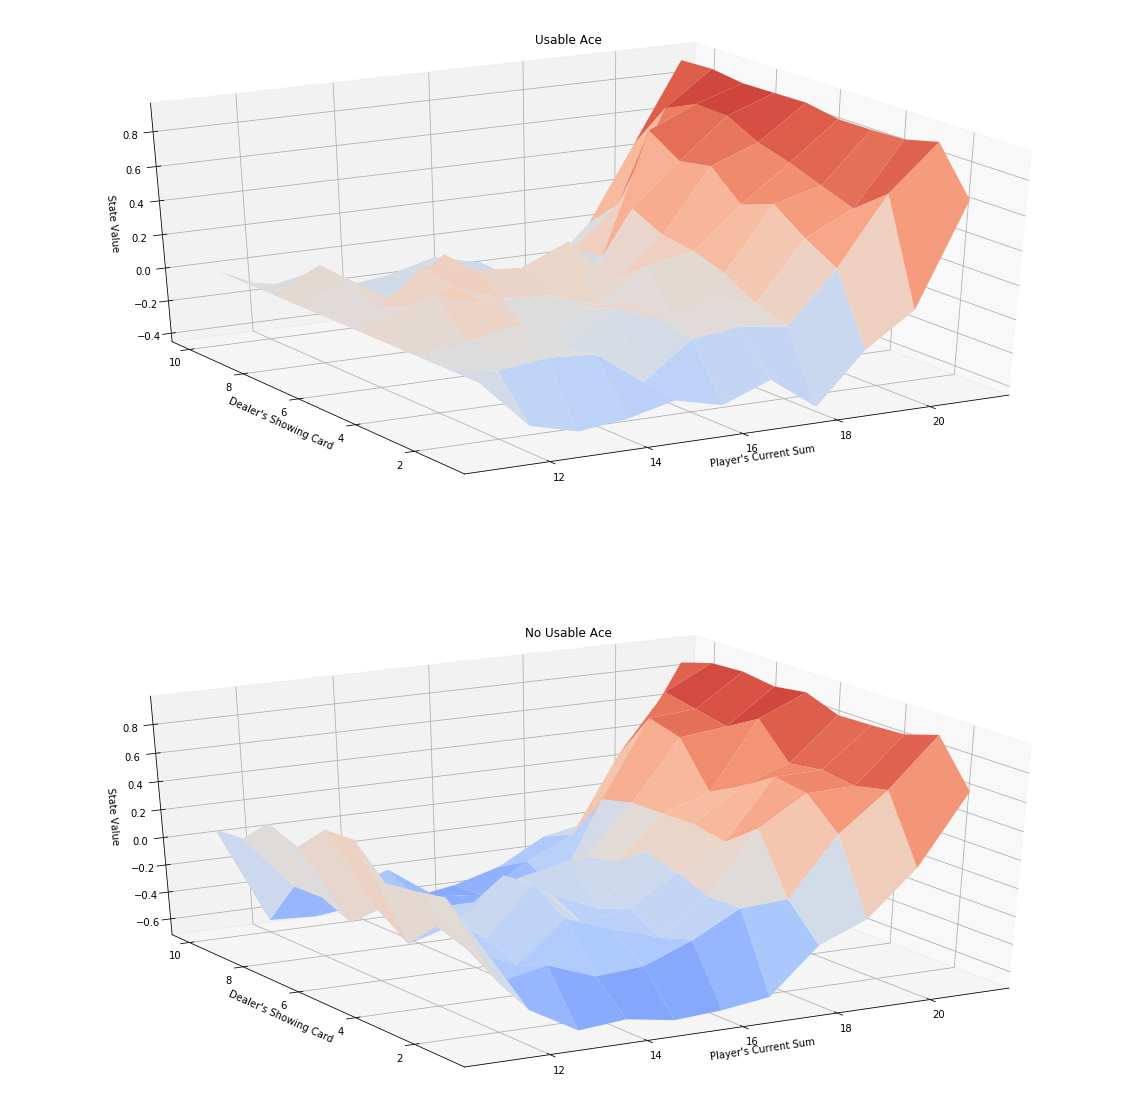

In [78]:
# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V)

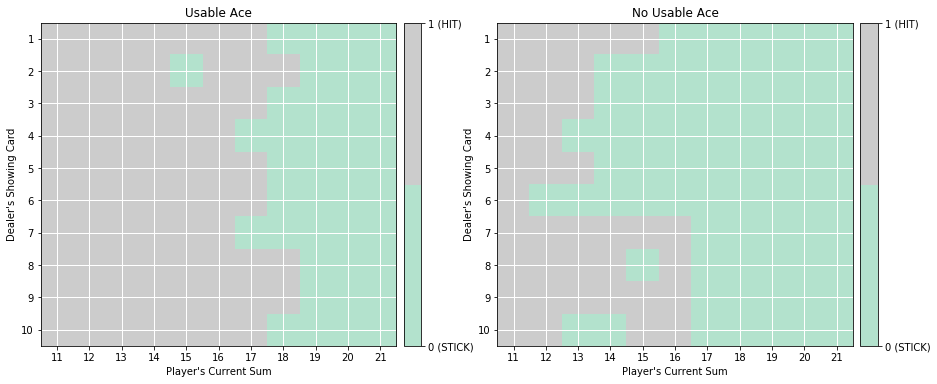

In [80]:
# plot the policy
optimal_policy = dict((state, np.argmax(actions)) \
                      for state, actions in Q.items())
plot_policy(optimal_policy)

The **true** optimal policy $\pi_*$ can be found in Figure 5.2 of the [textbook](http://go.udacity.com/rl-textbook) (and appears below).  Compare your final estimate to the optimal policy - how close are you able to get?  If you are not happy with the performance of your algorithm, take the time to tweak the decay rate of $\epsilon$, change the value of $\alpha$, and/or run the algorithm for more episodes to attain better results.

![True Optimal Policy](images/optimal.png)

### References

`[1]` Udacity. *Reinforcement Learning Cheatsheet*. Deep Reinforcement Learning for Enterprise Nanodegree Program. 2019. https://github.com/udacity/deep-reinforcement-learning/blob/master/cheatsheet/cheatsheet.pdf

`[2]` Udacity. *Epsilon-Greedy Policies*. Deep Reinforcement Learning for Enterprise Nanodegree Program, Part 1, Lesson 6. 2019.